In [1]:
random_state = 9911

In [3]:
import pickle
import sys
sys.path.append('/nfs/home/genovese/thesis-wildfire-genovese/src/')
import utils
from importlib import reload
reload(utils)
from utils import *


grid = gpd.read_file('/nfs/home/genovese/thesis-wildfire-genovese/outputs/kriged_map/grid_100m_piedmont.geojson')

In [ ]:
file_dir = '/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/database/kriged_maps/'

for map in tqdm(os.listdir(file_dir)):
    with open(file_dir+f'{map}', 'rb') as f:
        model = pickle.load(f)
    values = model.predict(np.array(pd.concat([grid.geometry.x, grid.geometry.y], axis=1)))
    pd.Series(values).to_csv(f'/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/database/kriged_map_values/{map.split(".")[0]}.csv')

In [24]:
# binning into 10 intervals of [0, 1]
aux = pd.concat([grid, pd.Series(values, name='target')], axis=1)
aux.loc[: ,'target'] = aux.loc[:, 'target'].round(1)

In [31]:
sample = gpd.GeoDataFrame(columns=['geometry', 'target', 'YYYY'])
# n_minor_class = aux.target.value_counts().iloc[-1]

for value, gdf in aux.groupby('target'):
    foo = gdf.sample(1000, random_state=random_state+int(value*25))
    sampled_years = np.random.randint(2016, 2025, size=1000)
    foo = pd.concat([foo, pd.Series(sampled_years, name='YYYY', index=foo.index)], axis=1)
    sample = pd.concat([sample, foo], axis=0, ignore_index=True)

/tmp/ipykernel_1047119/3347352304.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sample = pd.concat([sample, foo], axis=0, ignore_index=True)


<Figure size 600x600 with 0 Axes>

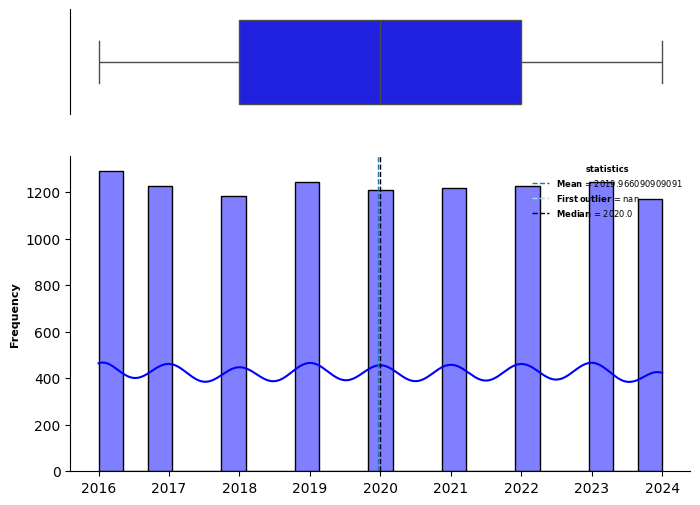

In [33]:
histbox(sample.YYYY);

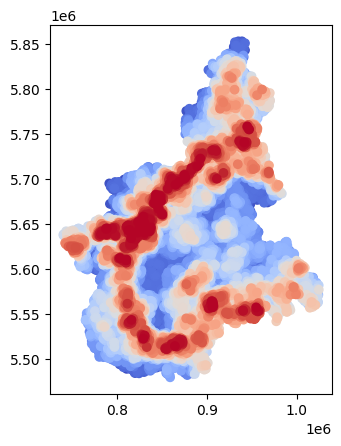

In [34]:
sample.plot(c=sample.target, cmap='coolwarm');

In [35]:
sample.index.name = 'fire_id'

In [39]:
sample.to_file('/nfs/home/genovese/thesis-wildfire-genovese/database/cache_resampled/dataset.geojson', driver='GeoJSON')

---